# **AI4ER Guided Team Challenge - Slow Earthquake Time Series Forecasting**
## Applying Machine Learning to Earthquake Data from Simulations, the Laboratory and Nature
**Authors:** Camilla Giulia Billari<sup>1</sup>, Pritthijit Nath<sup>1</sup>, Jakob Poffley<sup>1</sup>, Thomas Ratsakatika<sup>1</sup>, Alexandre Shinebourne<sup>1</sup>

**Supervisor:** Adriano Gualandi<sup>1</sup>

_<sup>1</sup> University of Cambridge_

___

## Introduction

This notebook allows the user to train and evaluate a machine learning model on their choice of simulated or laboratory "labquake" shear stress data, or slow earthquake slip potency data from Cascadia. It provides a step-by-step walkthrough of our pre-processing, training and evaluation logic, complementing the script-based implementation referenced in the README. The notebook relies on functions stored in the "utils" and "scripts/models" folders, to which all team members have contributed.

This notebook is designed to enable the user to easily modify the following parameters:

- **Model type:** Long Short-Term Memory (LSTM) or Temporal Convolutional Network (TCN)
- **Data source:** Simulations (b726, b698, i417), Laboratory (p4581, p4679, b726, b698, i417) or Nature (Cascadia)
- **Input features:** Shear stress/slip potency [required], variance, first derivative, second derivative, time since peak, time since failure [optional]
- **Data pre-processing:** Smoothing window, downsampling factor, validation/test set size
- **Modelling hyperparameters:** Forecast steps, lookback steps, number of epochs, hidden layer size, number of layers (LSTM only), kernel size (TCN only), dropout rate (TCN only)

Once trained, the model will generate one-shot (as opposed to auto-regressive) multi-step predictions of shear stress/slip potency. The accuracy of the model can be evaluated on using Root Mean Squared Error (RMSE) and R<sup>2</sup> statistics, as well as visually using the plotting functions.

Further details on the data and methodology, as well as an analysis and discussion of the results can be found in the accompanying report.
___

## Step 1: Environment set-up and imports

This notebook and associated functions have been designed to work in a Conda environment within a JASMIN group workspace. New users must therefore install the Conda environment, download the data to their working directory, and ensure the file paths are correct.

#### Installing the Conda environment

1. Install Miniconda if required (https://docs.anaconda.com/free/miniconda/miniconda-install/)
2. Source Conda and ensure it is properly installed:

   `source ~/miniconda3/bin/activate`

   `conda --version`
3. Clone the GitHub repository (https://github.com/ai4er-cdt/earthquake-predictability.git) to your desired location.
4. Navigate to the earthquake-predictability folder and create the Conda environment:

   `conda env create -f environment.yaml` if your machine has a GPU, otherwise use `conda env create -f environment-nogpu.yaml` 

   `conda activate gtc_env`

#### Download the slow earthquake data

1. [Download the simulation, labquake and cascadia slow earthquake data from Google Drive](https://drive.google.com/drive/folders/1PwO-OKlLo34oC8-NJ-Nd1qKLRvIdAx9n?usp=drive_link). You may need to request permission from Adriano Gualandi.
2. Save the three data folders in the following location within your working directory (create new folders as necessary): ../earthquake-predictability/data_local/gtc_quakes_data/
3. Note that the "data_local" directory is required when operating outside the JASMIN group workspace

#### Update the paths.py script

1. Run the following code to retrieve your hostname and username:

In [1]:
import getpass
import socket

print("Host name: ", socket.gethostname())  # Retrieve the hostname of the current system to determine the environment
print("User name: ", getpass.getuser())  # Retrieve the current user's username

Host name:  sci1.jasmin.ac.uk
User name:  trr26


2. Open "../earthquake-predictability/utils/paths.py" in a code editor of your choice.
3. Replace "new_user" in line 49 with your username. Replace "new_user_working_directory" in line 51 with the path to your cloned directory:

    `if "new_user" in username:`

        `    # Define the main directory on Tom's local machine for earthquake predictability`
    
        `    MAIN_DIRECTORY = "new_user_working_directory"`

4. *Note:* if you are on JASMIN (i.e. your hostname ends with jasmin.ac.uk) you must instead change the "MAIN_DIRECTORY" path in line 32:

    `MAIN_DIRECTORY = (`

    `    f"/gws/nopw/j04/ai4er/users/{jasmin_user}/earthquake-predictability"`

    `)`

### Imports

You should now be able to run the following cell which:

- Sets the system directories
- Imports the standard and custom functions
- Sets the random seed for Numpy and PyTorch
- Checks if a GPU is available

In [1]:
# Set the system directories
import sys
from utils.paths import MAIN_DIRECTORY
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import the standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Import local modules - note: dependent on above path being set correctly
import scripts.models.lstm_oneshot_multistep as lstm
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    create_dataset,
    moving_average_causal_filter,
    split_train_test_forecast_windows,
    find_peak_indices,
    create_features
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import plot_example_sample, plot_single_seg_result

# Set a random seed and torch device
SEED = 42
set_seed(SEED)
device = set_torch_device()

No GPU available.


___
## Step 2: Select an experiment and load the data

We have fictional shear stress (MPa) time series for:

- Labquake experiments conducted by Marone et al. (p4679, p4581)
- Labquake experiments conducted by Mele Veedu et al. (b726, b698, i417)
- Simulations of the Mele Veedu et al. labquake experiments conducted by Gualandi et al. (sim_b726, sim_b698, sim_i417)

We also have slip potency (a measure of displacement along a fault in m<sup>3</sup>) time series for Cascadia from Michel et al.

[A plot of the experiment and Cascadia time series can be found here](./images/trr26-notebooks/all_exp_shear_stress.png). Specific details on each time series can be found in the report.

**Update the variable "exp" with the experiment you want to train a model on.** Enter either "b726", "b698", "i417", "p4679", "p4581", "sim_b726", "sim_b698", "sim_i417" or "cascadia"

The "SlowEarthquakeDataset" class loads the shear stress/slip potency for the chosen experiment, ignoring any other columns (e.g. normal stress). It then converts the data into a dataframe, "df", which contains a single column called "signal". A sample from df is then printed, alongside its shape for inspection.

In [7]:
exp = "b726"    # Set this to the name of the experiment you want to train on


if exp == "cascadia":
    column_name = "seg_avg"
else:
    column_name = "obs_shear_stress"

dataset = SlowEarthquakeDataset(exp)
df = pd.DataFrame(
    SlowEarthquakeDataset.convert_to_df(dataset, exp)[column_name].rename(
        "signal"
    )
)

if exp == "cascadia":
    df = df / 1e8  # Scale the slip potency signal to match magnitude of lab and sim data

df

,signal
0,9.515997
1,9.519734
2,9.517776
3,9.523571
4,9.522370
...,...
19996,9.390598
19997,9.391377
19998,9.389498
19999,9.388610


## Step 3: Pre-process the data

The next cell applies a custom causal filter to the signal. The function:

- Smooths the data using a trailing moving average with a window size equal to "smoothing_window".
- It then downsamples the data with a step size equal to the "downsampling_factor"

**We downsample the data because each time step should represent the same amount of "movement" for all of our datasets.** I.e. if it takes 30 time steps to go from a peak to a trough in Cascadia, it should take 30 time steps to do the same in our experiments. This is important because our models are trained to predict a fixed number of steps forward. This fixed "look forward" must represent the same "movement" in the simulated, laboratory and Cascadia data to enable comparison and transfer learning.

The "settings" dictionary in the cell below contains the downsampling_factors required to ensure the experiment data aligns with Cascadia. [A plot of the aligned data can be viewed here](./images/trr26-notebooks/downsampling_alignment.png) (the black dotted lines represent 30 time steps).

The dictionary also includes smoothing_window sizes for each experiment  which you may adjust if desired.  

In [8]:
# Define smoothing window and downsampling factor for each experiment (must be integers)
settings = {
    "cascadia": {"smoothing_window": 10, "downsampling_factor": 1},
    "p4679": {"smoothing_window": 20, "downsampling_factor": 13},
    "p4581": {"smoothing_window": 26, "downsampling_factor": 26},
    "b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "i417": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_b726": {"smoothing_window": 1, "downsampling_factor": 1},
    "sim_b698": {"smoothing_window": 2, "downsampling_factor": 2},
    "sim_i417": {"smoothing_window": 2, "downsampling_factor": 2},
}

df_filtered = moving_average_causal_filter(df, **settings[exp])

df_filtered

,signal
0,9.515997
1,9.519734
2,9.517776
3,9.523571
4,9.522370
...,...
19996,9.390598
19997,9.391377
19998,9.389498
19999,9.388610


## Step 4: Engineer new input features

The next cell adds engineered input features to the data frame using the create_features function. "create_features" adds calculates the variance, first derivative, second derivative, the times since the last peak and the time since the last trough.

All the features are added to the dataframe at this stage to enable experimentation with different feature combinations when training the model.

The resulting dataframe now has six columns, as shown below.

In [9]:
df_features = create_features(df_filtered.copy())

df_features

,signal,variance,first_derivative,second_derivative,steps_since_last_peak,steps_since_last_trough
0,9.534869,0.000041,-0.002361,0.002832,29.0,29.0
1,9.527865,0.000035,-0.007004,-0.004643,30.0,30.0
2,9.532080,0.000031,0.004216,0.011220,31.0,31.0
3,9.534280,0.000025,0.002200,-0.002016,32.0,32.0
4,9.535957,0.000024,0.001677,-0.000523,33.0,33.0
...,...,...,...,...,...,...
19967,9.390598,0.000143,0.001887,-0.007142,196.0,110.0
19968,9.391377,0.000145,0.000779,-0.001108,197.0,111.0
19969,9.389498,0.000149,-0.001879,-0.002658,198.0,112.0
19970,9.388610,0.000153,-0.000887,0.000992,199.0,113.0


### Plot the data including engineered features

The next cell plots signal column alongside the engineered features for inspection.

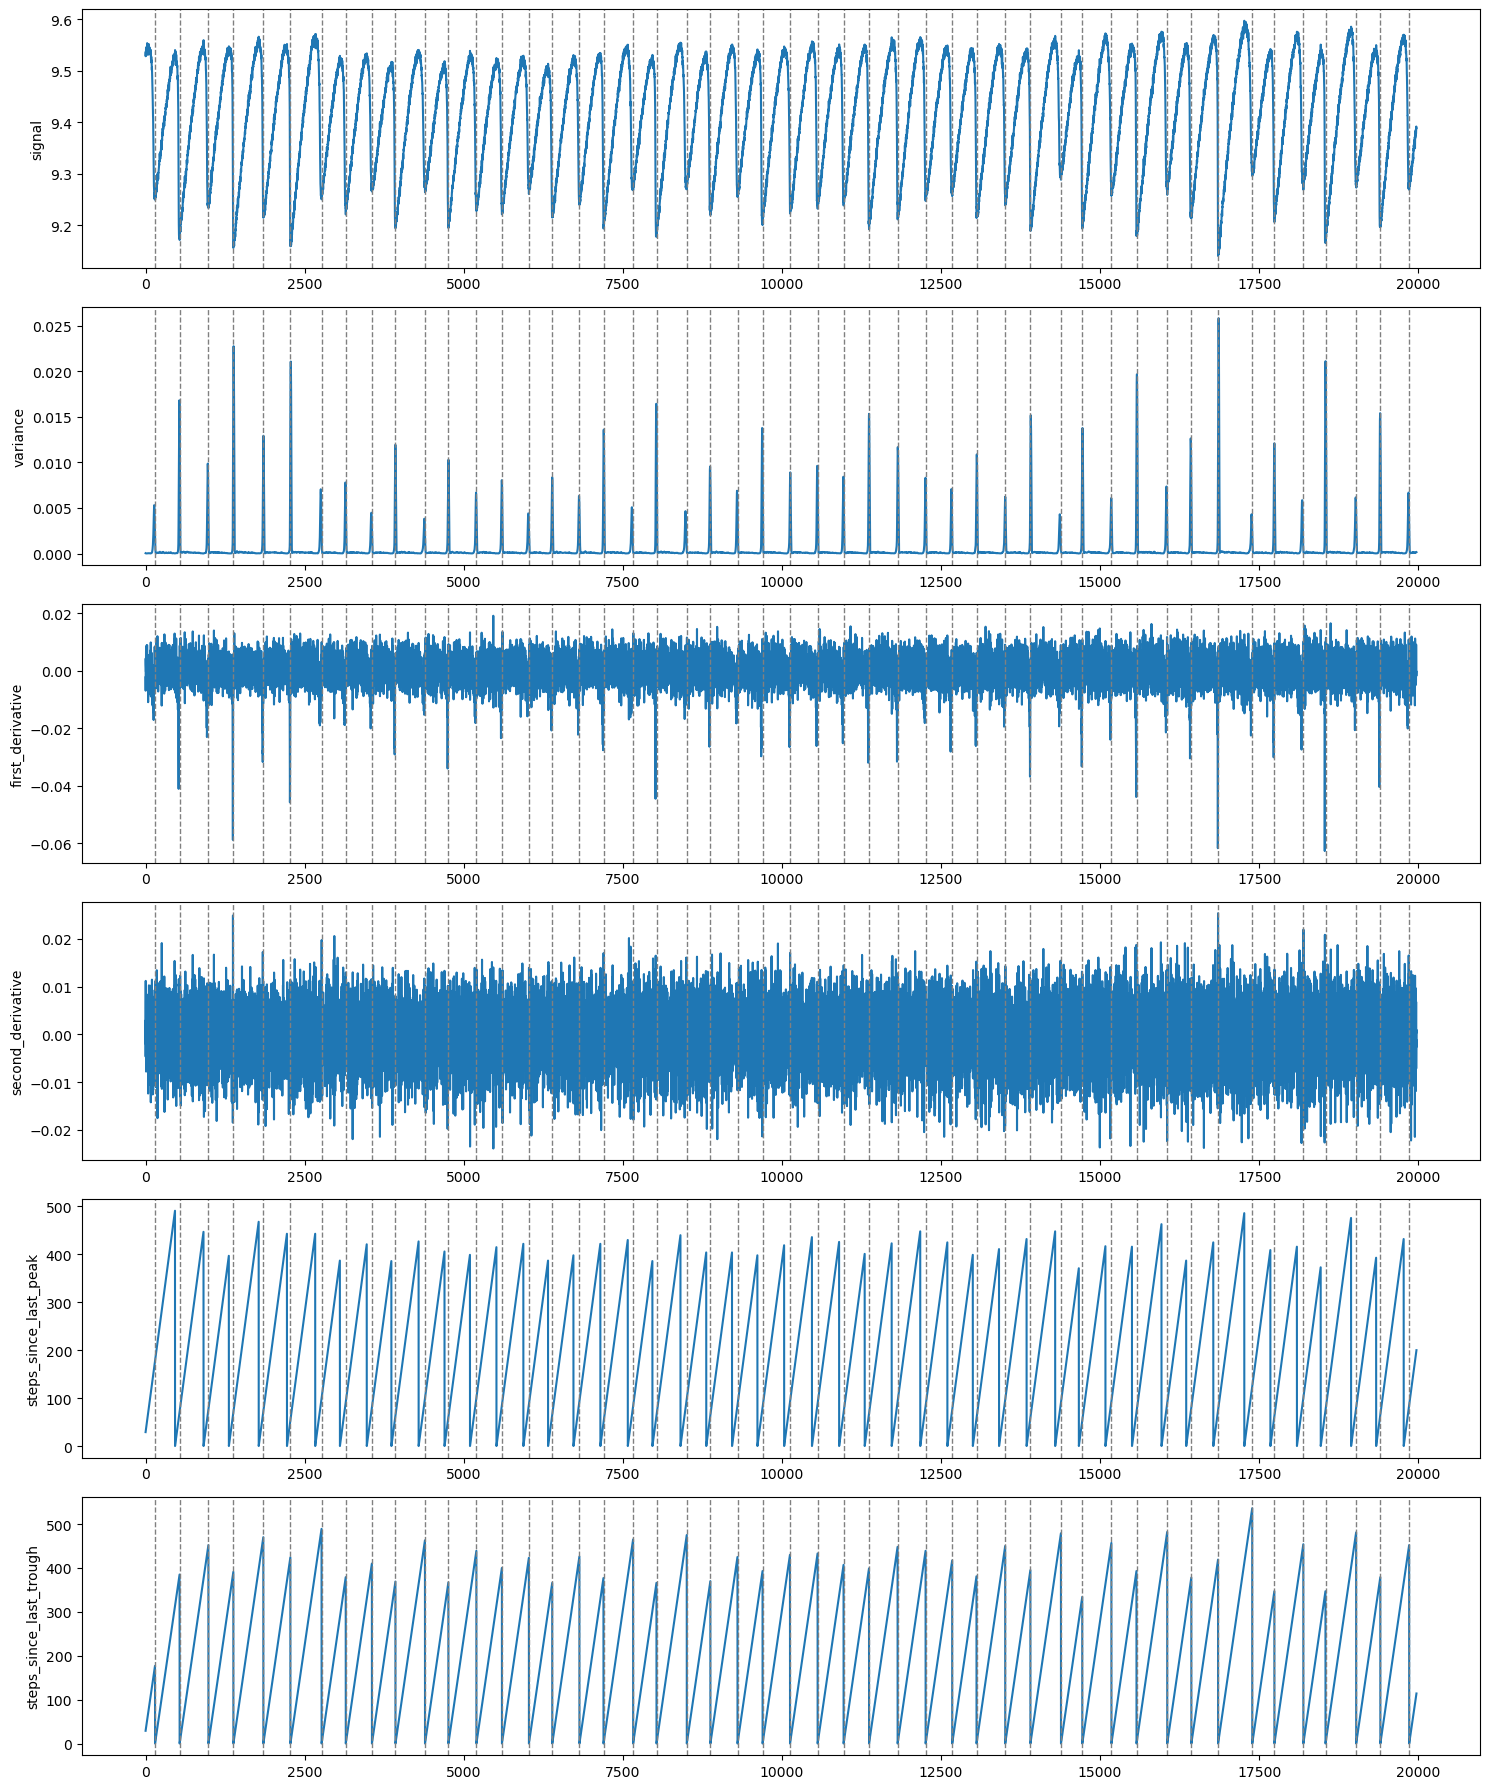

In [10]:
fig, axs = plt.subplots(
    len(df_features.columns), 1, figsize=(15, 3 * len(df_features.columns))
)

for i, column in enumerate(df_features.columns):
    ax = axs[i]
    ax.plot(df_features.index, df_features[column])
    ax.set_ylabel(column)
    ax.grid(False)

    # Mark where steps_since_last_trough = 0 with a thin red dashed line
    troughs_indices = df_features[
        df_features["steps_since_last_trough"] == 0
    ].index
    for trough_index in troughs_indices:
        ax.axvline(x=trough_index, color="grey", linestyle="--", linewidth=1)

    # if column in ['variance', 'first_derivative', 'second_derivative']:
    #    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [8]:
LOOKBACK, FORECAST = 600, 30  # need to adjust back to 60
X, y = create_dataset(df_features, LOOKBACK, FORECAST)

print(f"X and y shapes:\t{X.shape}\t{y.shape}")

X and y shapes:	torch.Size([3216, 600, 6])	torch.Size([3216, 30, 6])


In [9]:
N_FORECAST_WINDOWS = 12
N_VALIDATION_WINDOWS = 12

(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print("Split dataset statistics:")
print(f"Training data shapes:\t\t{X_train.shape}\t\t{y_train.shape}")
print(f"Testing data shapes:\t\t{X_val.shape}\t\t{y_val.shape}")
print(f"Validation data shapes:\t\t{X_test.shape}\t\t{y_test.shape}")

Split dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def normalise_dataset_multi_feature(
    X_train, y_train, X_test, y_test, X_val=None, y_val=None
):
    num_features = X_train.shape[2]

    # Initialize a list of scalers, one for each feature
    scalers_X = [StandardScaler() for _ in range(num_features)]
    scalers_y = [StandardScaler() for _ in range(num_features)]

    # Normalize each feature in X
    X_train_sc = np.zeros_like(X_train)
    X_test_sc = np.zeros_like(X_test)
    X_val_sc = None if X_val is None else np.zeros_like(X_val)

    for i in range(num_features):
        # Reshape for fitting: (samples * timesteps, 1)
        X_train_reshaped = X_train[:, :, i].reshape(-1, 1)
        scalers_X[i].fit(X_train_reshaped)

        # Transform training data
        X_train_sc[:, :, i] = (
            scalers_X[i]
            .transform(X_train_reshaped)
            .reshape(X_train.shape[0], X_train.shape[1])
        )

        # Transform test data
        X_test_reshaped = X_test[:, :, i].reshape(-1, 1)
        X_test_sc[:, :, i] = (
            scalers_X[i]
            .transform(X_test_reshaped)
            .reshape(X_test.shape[0], X_test.shape[1])
        )

        # Transform validation data if provided
        if X_val is not None:
            X_val_reshaped = X_val[:, :, i].reshape(-1, 1)
            X_val_sc[:, :, i] = (
                scalers_X[i]
                .transform(X_val_reshaped)
                .reshape(X_val.shape[0], X_val.shape[1])
            )

    # Assuming the same structure for y
    y_train_sc = np.zeros_like(y_train)
    y_test_sc = np.zeros_like(y_test)
    y_val_sc = None if y_val is None else np.zeros_like(y_val)

    scalers_y = scalers_X  # PREVENTS CREATION OF SEPARATE SCALAR FOR YS

    for i in range(num_features):
        y_train_reshaped = y_train[:, :, i].reshape(-1, 1)
        # scalers_y[i].fit(y_train_reshaped)

        y_train_sc[:, :, i] = (
            scalers_y[i]
            .transform(y_train_reshaped)
            .reshape(y_train.shape[0], y_train.shape[1])
        )
        y_test_reshaped = y_test[:, :, i].reshape(-1, 1)
        y_test_sc[:, :, i] = (
            scalers_y[i]
            .transform(y_test_reshaped)
            .reshape(y_test.shape[0], y_test.shape[1])
        )

        if y_val is not None:
            y_val_reshaped = y_val[:, :, i].reshape(-1, 1)
            y_val_sc[:, :, i] = (
                scalers_y[i]
                .transform(y_val_reshaped)
                .reshape(y_val.shape[0], y_val.shape[1])
            )

    # Convert back to PyTorch tensors
    data_dict = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "X_train_sc": torch.tensor(X_train_sc, dtype=torch.float),
        "y_train_sc": torch.tensor(y_train_sc, dtype=torch.float),
        "X_test_sc": torch.tensor(X_test_sc, dtype=torch.float),
        "y_test_sc": torch.tensor(y_test_sc, dtype=torch.float),
    }

    if X_val is not None and y_val is not None:
        data_dict.update(
            {
                "X_val": X_val,
                "y_val": y_val,
                "X_val_sc": torch.tensor(X_val_sc, dtype=torch.float)
                if X_val_sc is not None
                else None,
                "y_val_sc": torch.tensor(y_val_sc, dtype=torch.float)
                if y_val_sc is not None
                else None,
            }
        )

    return data_dict, scalers_X, scalers_y

In [11]:
data_dict_temp, scalers_X, scalers_y = normalise_dataset_multi_feature(
    X_train, y_train, X_test, y_test, X_val, y_val
)

print(f"Data Dictionary keys:\t{data_dict_temp.keys()}")
print("------------------")
print("Original dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict_temp['X_train'].shape}\t\t{data_dict_temp['y_train'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict_temp['X_val'].shape}\t\t{data_dict_temp['y_val'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict_temp['X_test'].shape}\t\t{data_dict_temp['y_test'].shape}"
)
print("------------------")
print("Normalised dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict_temp['X_train_sc'].shape}\t\t{data_dict_temp['y_train_sc'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict_temp['X_val_sc'].shape}\t\t{data_dict_temp['y_val_sc'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict_temp['X_test_sc'].shape}\t\t{data_dict_temp['y_test_sc'].shape}"
)

Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([2490, 600, 6])		torch.Size([2490, 30, 6])
Validation data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])
Testing data shapes:		torch.Size([360, 600, 6])		torch.Size([360, 30, 6])


In [12]:
# Function to plot a random window


def plot_random_window():
    random_index = np.random.randint(0, data_dict_temp["X_train_sc"].shape[0])
    num_features = data_dict_temp["X_train_sc"].shape[2]
    fig, axs = plt.subplots(
        num_features // 2 + num_features % 2,
        2,
        figsize=(15, num_features * 1.5),
    )

    for i in range(num_features):
        row, col = divmod(i, 2)
        feature_name = df_features.columns[
            i
        ]  # Get the column heading from df_features
        axs[row, col].plot(
            data_dict_temp["X_train_sc"][random_index, :, i], label="X_train"
        )
        axs[row, col].plot(
            np.arange(
                data_dict_temp["X_train_sc"].shape[1],
                data_dict_temp["X_train_sc"].shape[1]
                + data_dict_temp["y_train_sc"].shape[1],
            ),
            data_dict_temp["y_train_sc"][random_index, :, i],
            label="y_train",
        )
        axs[row, col].set_title(
            feature_name
        )  # Set the plot title to the column heading
        axs[row, col].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

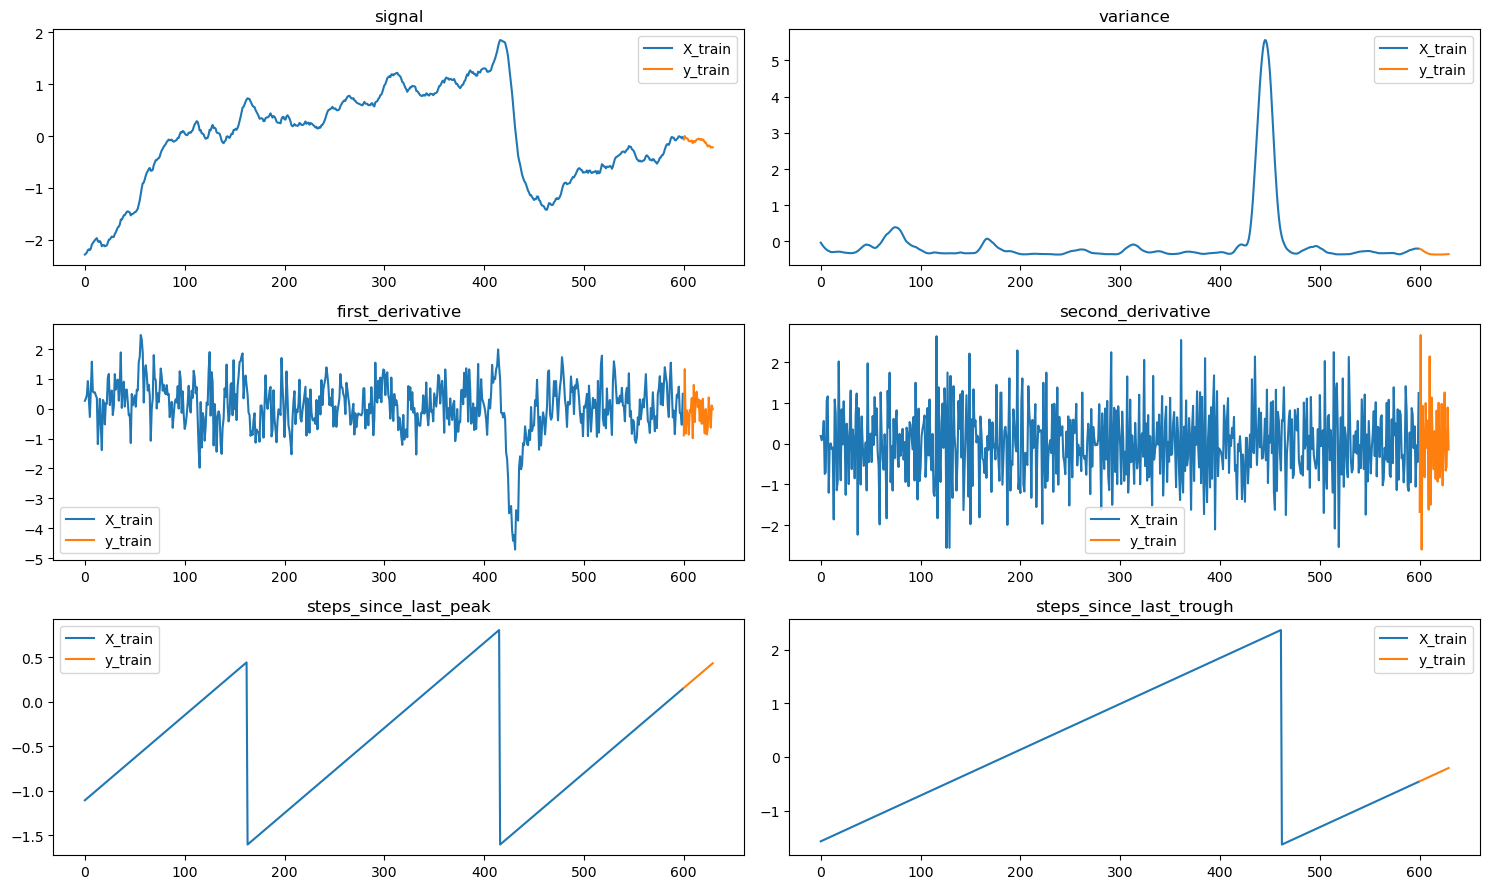

In [13]:
# Initial plot
plot_random_window()

In [14]:
def select_features(data_dict_temp, feature_names):
    # Map feature names to their indices
    feature_map = {
        "signal": 0,
        "variance": 1,
        "first_derivative": 2,
        "second_derivative": 3,
        "steps_since_last_peak": 4,
        "steps_since_last_trough": 5,
    }

    # Convert feature names to indices
    feature_indices = [
        feature_map[name] for name in feature_names if name in feature_map
    ]

    # Select features based on the indices
    data_dict = {
        "X_train": data_dict_temp["X_train"][:, :, feature_indices],
        "X_test": data_dict_temp["X_test"][:, :, feature_indices],
        "X_val": data_dict_temp["X_val"][:, :, feature_indices],
        "y_train": data_dict_temp["y_train"][:, :, 0],
        "y_test": data_dict_temp["y_test"][:, :, 0],
        "y_val": data_dict_temp["y_val"][:, :, 0],
        "X_train_sc": data_dict_temp["X_train_sc"][:, :, feature_indices],
        "X_test_sc": data_dict_temp["X_test_sc"][:, :, feature_indices],
        "X_val_sc": data_dict_temp["X_val_sc"][:, :, feature_indices],
        "y_train_sc": data_dict_temp["y_train_sc"][:, :, 0],
        "y_test_sc": data_dict_temp["y_test_sc"][:, :, 0],
        "y_val_sc": data_dict_temp["y_val_sc"][:, :, 0],
    }

    return data_dict

In [15]:
features_to_keep = ["signal", "variance"]
data_dict = select_features(data_dict_temp, features_to_keep)

print(f"Data Dictionary keys:\t{data_dict.keys()}")
print("------------------")
print("Original dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict['X_train'].shape}\t\t{data_dict['y_train'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_val'].shape}\t\t{data_dict['y_val'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_test'].shape}\t\t{data_dict['y_test'].shape}"
)
print("------------------")
print("Normalised dataset statistics:")
print(
    f"Training data shapes:\t\t{data_dict['X_train_sc'].shape}\t\t{data_dict['y_train_sc'].shape}"
)
print(
    f"Validation data shapes:\t\t{data_dict['X_val_sc'].shape}\t\t{data_dict['y_val_sc'].shape}"
)
print(
    f"Testing data shapes:\t\t{data_dict['X_test_sc'].shape}\t\t{data_dict['y_test_sc'].shape}"
)

Data Dictionary keys:	dict_keys(['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val', 'X_train_sc', 'X_test_sc', 'X_val_sc', 'y_train_sc', 'y_test_sc', 'y_val_sc'])
------------------
Original dataset statistics:
Training data shapes:		torch.Size([2490, 600, 2])		torch.Size([2490, 30])
Testing data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
Validation data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
------------------
Normalised dataset statistics:
Training data shapes:		torch.Size([2490, 600, 2])		torch.Size([2490, 30])
Validation data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])
Testing data shapes:		torch.Size([360, 600, 2])		torch.Size([360, 30])


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import tqdm
from sklearn.metrics import r2_score


def train_model(model, n_epochs, data_dict, scaler_y, device):
    """
    Train a model for time series forecasting, optionally using a validation set.

    Parameters:
        model (nn.Module): model to be trained.
        n_epochs (int): Number of training epochs.
        data_dict (dict): Dictionary containing training, optional validation, and testing data arrays.
        scaler_y: Scaler for the target variable.
        device: Device (CPU or CUDA) to train the model on.

    Returns:
        dict: Dictionary containing the training, optional validation, and testing predictions,
                as well as lists of training, validation (if applicable), and testing RMSE and R2 values.
    """

    print(f"Training model on {device}")

    # Move model to the specified device
    model = model.to(device)

    # Prepare data
    X_train_sc = data_dict["X_train_sc"].to(device)
    y_train_sc = data_dict["y_train_sc"].to(device)

    # Lists for storing metrics
    train_rmse_list, train_r2_list = [], []

    # Check for validation set
    has_val = "X_val_sc" in data_dict and "y_val_sc" in data_dict
    if has_val:
        X_val_sc = data_dict["X_val_sc"].to(device)
        val_rmse_list, val_r2_list = [], []
    else:
        X_test_sc = data_dict["X_test_sc"].to(device)
        test_rmse_list, test_r2_list = [], []

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    # DataLoader for training data
    loader = data.DataLoader(
        data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=32
    )

    # Training loop
    pbar = tqdm.tqdm(range(n_epochs))
    for epoch in pbar:
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate performance
        model.eval()
        with torch.no_grad():
            # Training data evaluation
            y_train_pred = model(X_train_sc)
            y_train_pred_inv = torch.Tensor(
                scaler_y.inverse_transform(y_train_pred.cpu().detach().numpy())
            )
            # train_rmse = np.sqrt(loss_fn(y_train_pred_inv, data_dict["y_train"].to(device))).item()
            train_rmse = np.sqrt(
                loss_fn(y_train_pred_inv.cpu(), data_dict["y_train"].cpu())
            ).item()
            train_r2 = r2_score(
                data_dict["y_train"], y_train_pred_inv.cpu().detach().numpy()
            )

            # Update lists and progress bar
            train_rmse_list.append(train_rmse)
            train_r2_list.append(train_r2)

            # Validation data evaluation (if available)
            if has_val:
                y_val_pred = model(X_val_sc)
                y_val_pred_inv = torch.Tensor(
                    scaler_y.inverse_transform(
                        y_val_pred.cpu().detach().numpy()
                    )
                )
                # val_rmse = np.sqrt(loss_fn(y_val_pred_inv, data_dict["y_val"].to(device))).item()
                val_rmse = np.sqrt(
                    loss_fn(y_val_pred_inv.cpu(), data_dict["y_val"].cpu())
                ).item()
                val_r2 = r2_score(
                    data_dict["y_val"], y_val_pred_inv.cpu().detach().numpy()
                )

                # Update lists and progress bar
                val_rmse_list.append(val_rmse)
                val_r2_list.append(val_r2)

            else:  # Testing data evaluation
                y_test_pred = model(X_test_sc)
                y_test_pred_inv = torch.Tensor(
                    scaler_y.inverse_transform(
                        y_test_pred.cpu().detach().numpy()
                    )
                )
                # test_rmse = np.sqrt(loss_fn(y_test_pred_inv, data_dict["y_test"].to(device))).item()
                test_rmse = np.sqrt(
                    loss_fn(y_test_pred_inv.cpu(), data_dict["y_test"].cpu())
                ).item()
                test_r2 = r2_score(
                    data_dict["y_test"], y_test_pred_inv.cpu().detach().numpy()
                )

                # Update lists and progress bar
                test_rmse_list.append(test_rmse)
                test_r2_list.append(test_r2)

        if has_val:
            pbar_desc = f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}"
        else:
            pbar_desc = f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"

        pbar.set_description(pbar_desc)

    # Compile results
    results_dict = {
        "y_train_pred": y_train_pred_inv.cpu(),
        "train_rmse_list": train_rmse_list,
        "train_r2_list": train_r2_list,
    }

    # Add val results
    if has_val:
        results_dict.update(
            {
                "y_val_pred": y_val_pred_inv.cpu(),
                "val_rmse_list": val_rmse_list,
                "val_r2_list": val_r2_list,
            }
        )
    else:  # Add test results
        results_dict.update(
            {
                "y_test_pred": y_test_pred_inv.cpu(),
                "test_rmse_list": test_rmse_list,
                "test_r2_list": test_r2_list,
            }
        )

    return results_dict

In [17]:
def eval_model_on_test_set(model, results_dict, data_dict, scaler_y, device):
    """
    Evaluate the model on the test set and return RMSE and R^2 metrics.

    Parameters:
        model (torch.nn.Module): Trained model.
        results_dict (dict): Dictionary containing training and validation predictions and metrics.
        data_dict (dict): Contains scaled test features ('X_test_sc') and original labels ('y_test').
        scaler_y (MinMaxScaler): Scaler for inverse transforming predictions.
        device (str): Device for computation ('cpu' or 'cuda').

    Returns:
        dict: Contains inverse transformed predictions ('y_test_pred'), RMSE ('test_rmse_list'), and R^2 ('test_r2_list').
    """

    # Load scaled test features
    X_test_sc = data_dict["X_test_sc"].to(device)

    # Predict and inverse transform to original scale
    y_test_pred = model(X_test_sc)

    # Define loss function as mean squared error
    loss_fn = nn.MSELoss()

    # Calculate RMSE and R^2
    y_test_pred_inv = torch.Tensor(
        scaler_y.inverse_transform(y_test_pred.cpu().detach().numpy())
    )
    # test_rmse = np.sqrt(loss_fn(y_test_pred_inv, data_dict["y_test"].to(device))).item()
    test_rmse = np.sqrt(
        loss_fn(y_test_pred_inv.cpu(), data_dict["y_test"].cpu())
    ).item()
    test_r2 = r2_score(
        data_dict["y_test"], y_test_pred_inv.cpu().detach().numpy()
    )

    # Compile results
    results_dict.update(
        {
            "y_test_pred": y_test_pred_inv.cpu(),
            "test_rmse_list": test_rmse,
            "test_r2_list": test_r2,
        }
    )
    return results_dict

In [35]:
# Model variables
N_VARIATES = data_dict["X_train"].shape[2]
HIDDEN_SIZE = 25
OUTPUT_SIZE = FORECAST
N_EPOCHS = 176
N_LAYERS = 1
scaler_y = scalers_y[0]

model = lstm.MultiStepLSTMSingleLayer(
    N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device
).to(device)

In [36]:
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


  0%|          | 0/176 [00:00<?, ?it/s]

Epoch [176/176], Train RMSE: 13592425.0000, Val RMSE: 32986212.0000: 100%|██████████| 176/176 [01:26<00:00,  2.03it/s]


In [37]:
results_dict = eval_model_on_test_set(
    model, results_dict, data_dict, scaler_y, device
)

Train RMSE: 13592425.0
Val RMSE: 32986212.0
Test RMSE: 53758140.0
--------------
Train R^2: 0.9509742290781272
Val R^2: 0.7611516996154728
Test R^2: 0.7180113927976843
--------------
Five lowest Validation RMSEs:
Epoch: 27, Value: 26183504.0 (R^2: 0.8495074100654442)
Epoch: 21, Value: 28680824.0 (R^2: 0.8194311341293478)
Epoch: 23, Value: 28872228.0 (R^2: 0.8170125920049198)
Epoch: 136, Value: 29812728.0 (R^2: 0.8048969134663377)
Epoch: 156, Value: 30165678.0 (R^2: 0.8002545902109985)


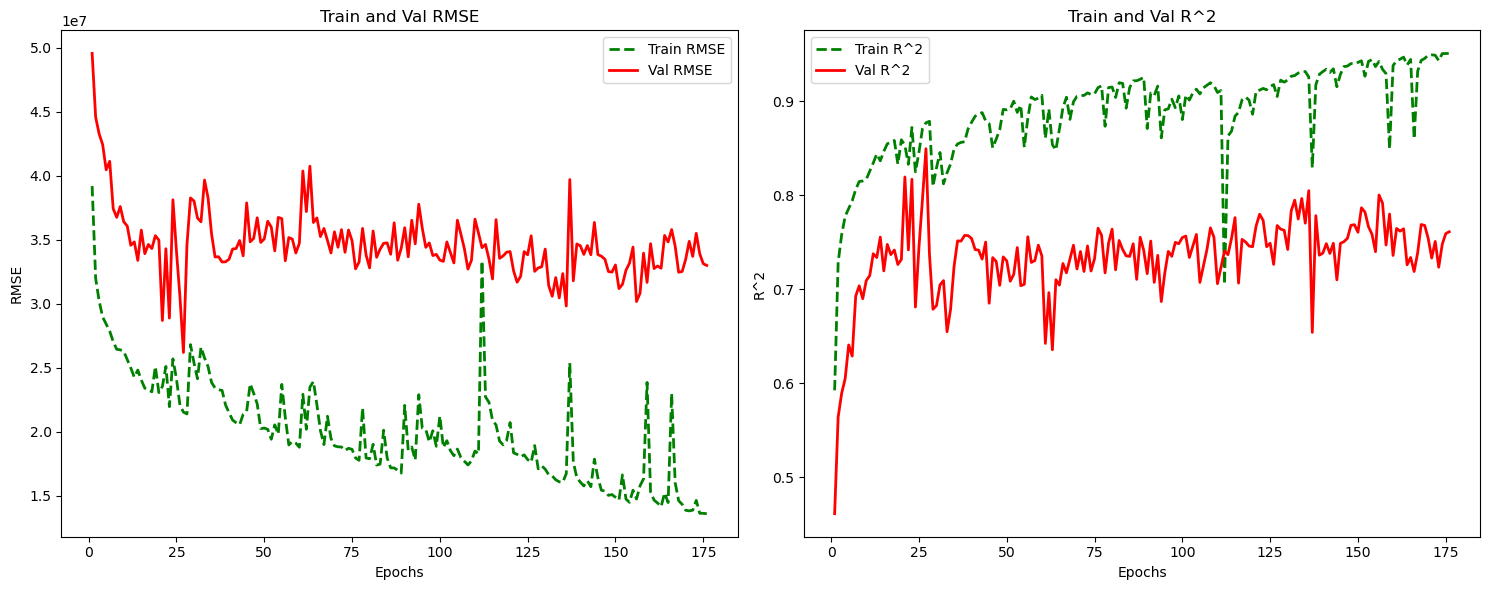

In [38]:
print("Train RMSE:", results_dict["train_rmse_list"][-1])
print("Val RMSE:", results_dict["val_rmse_list"][-1])
print("Test RMSE:", results_dict["test_rmse_list"])

print("--------------")

print("Train R^2:", results_dict["train_r2_list"][-1])
print("Val R^2:", results_dict["val_r2_list"][-1])
print("Test R^2:", results_dict["test_r2_list"])

val_rmse_list = results_dict["val_rmse_list"]
lowest_losses = sorted(enumerate(val_rmse_list), key=lambda x: x[1])[:5]

print("--------------")

print("Five lowest Validation RMSEs:")
for index, loss in lowest_losses:
    print(
        f"Epoch: {index + 1}, Value: {loss} (R^2: {results_dict['val_r2_list'][index]})"
    )

# Get the train and val RMSE lists from the results_dict}
train_rmse_list = results_dict["train_rmse_list"]
val_rmse_list = results_dict["val_rmse_list"]

# Get the train and val R^2 lists from the results_dict
train_r2_list = results_dict["train_r2_list"]
val_r2_list = results_dict["val_r2_list"]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot train and val RMSE
axs[0].plot(
    range(1, len(train_rmse_list) + 1),
    train_rmse_list,
    label="Train RMSE",
    color="green",
    linestyle="--",
    linewidth=2,
)
axs[0].plot(
    range(1, len(val_rmse_list) + 1),
    val_rmse_list,
    label="Val RMSE",
    color="red",
    linestyle="-",
    linewidth=2,
)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("RMSE")
axs[0].set_title("Train and Val RMSE")
axs[0].legend()

# Plot train and val R^2
axs[1].plot(
    range(1, len(train_r2_list) + 1),
    train_r2_list,
    label="Train R^2",
    color="green",
    linestyle="--",
    linewidth=2,
)
axs[1].plot(
    range(1, len(val_r2_list) + 1),
    val_r2_list,
    label="Val R^2",
    color="red",
    linestyle="-",
    linewidth=2,
)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("R^2")
axs[1].set_title("Train and Val R^2")
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [39]:
def plot_random_test_window(data_dict, results_dict):
    np.random.seed()  # Ensure different windows are selected each time
    random_index = np.random.randint(0, data_dict["X_test"].shape[0])

    # Extract the data for the chosen window
    X_test_window = (
        data_dict["X_test"][random_index, :, 0].cpu().numpy()
    )  # Assuming first feature is at index 0
    y_test_window = data_dict["y_test"][random_index, :].cpu().numpy()
    y_test_pred_window = (
        results_dict["y_test_pred"][random_index, :].cpu().numpy()
    )

    # Calculate the starting index for y_test and y_test_pred on the x-axis
    start_index_for_y = X_test_window.shape[0]

    # Create time steps for each series
    time_steps_X = np.arange(start_index_for_y)
    time_steps_y = np.arange(
        start_index_for_y, start_index_for_y + y_test_window.shape[0]
    )

    # Plotting
    plt.figure(figsize=(14, 6))

    # Plot the first feature from X_test
    plt.plot(
        time_steps_X,
        X_test_window,
        label="X_test (signal)",
        color="blue",
        linestyle="-",
    )

    # Plot the actual y_test with adjusted time steps
    plt.plot(
        time_steps_y,
        y_test_window,
        label="Actual y_test",
        color="green",
        linestyle="-",
    )

    # Plot the predicted y_test with adjusted time steps
    plt.plot(
        time_steps_y,
        y_test_pred_window,
        label="Predicted y_test",
        color="orange",
        linestyle="-",
    )

    plt.title(f"Test Window {random_index} - Actual vs. Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

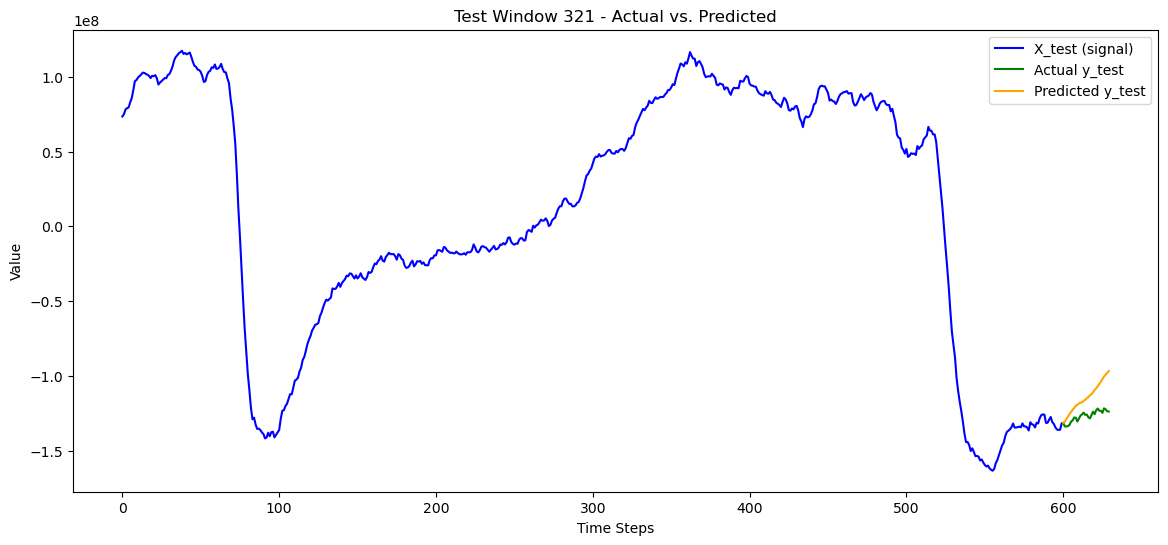

In [56]:
plot_random_test_window(data_dict, results_dict)